# DA Algorithm
### 中田 竜明

In [1]:
using DA

昨年のnotebookは[こちら](http://nbviewer.jupyter.org/github/nswa17/DA_alg.jl/blob/master/DA.ipynb?flush_cache=true)

1対1マッチングについて, (male-proposingと仮定して)マッチしていない男性をスタックに載せるなどの変更を加えました.
結果的に,

1. `while any(男性がマッチしていないかのbool配列)`の部分を`while スタックの長さの変数 > 0`とすることができ,
1. マッチしていない男性１人の取り出しを行う部分でループを回す必要もなくなったので,(`pop!(待ち男性のスタック)`とすればよい)

特にマッチングループ終盤で不必要なループ・条件式の評価がなくなりました.(プロファイルを確認したところこの部分に時間がかかっていたようです)

テストを行います.

In [2]:
Pkg.test("DA")

INFO: Testing DA


Test Summary:               | Pass  Total
  Testing deferred acceptance |   12     12


INFO: DA tests passed


In [3]:
m, n = 10, 10
m_prefs, f_prefs = generate_random_prefs(m, n)
m_matched, f_matched = deferred_acceptance(m_prefs, f_prefs)

([2,8,10,9,1,4,5,6,7,3],[5,1,10,6,7,8,9,2,4,3])

In [4]:
@time deferred_acceptance(m_prefs, f_prefs)

  0.000017 seconds (135 allocations: 9.344 KB)


([2,8,10,9,1,4,5,6,7,3],[5,1,10,6,7,8,9,2,4,3])

タイムを計測してみます.

In [5]:
for (m, n) in [(100, 100), (200, 200), (500, 500), (1000, 1000)]
    m_prefs, f_prefs = generate_random_prefs(m, n)
    m_matched, f_matched = @time deferred_acceptance(m_prefs, f_prefs)
end

  0.000077 seconds (8 allocations: 82.563 KB)
  0.000249 seconds (8 allocations: 321.250 KB)
  0.001965 seconds (8 allocations: 1.927 MB)
  0.012523 seconds (9 allocations: 7.668 MB, 37.19% gc time)


In [6]:
Profile.clear()
m, n = 10^4, 10^4
m_prefs, f_prefs = generate_random_prefs(m, n)
deferred_acceptance(m_prefs, f_prefs)
@profile deferred_acceptance(m_prefs, f_prefs)
Profile.print()

772 ./task.jl:360; (::IJulia.##13#19)()
 772 ...Julia/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  772 ...rc/execute_request.jl:156; execute_request(::ZMQ.Socket, ::...
   772 ./loading.jl:441; include_string(::String, ::String)
    771 ./<missing>:?; anonymous
     771 ./profile.jl:16; macro expansion;
      361 ...ia/v0.5/DA/src/DA.jl:8; main(::Array{Array{Int64,1},1}...
       303 ./array.jl:158; fill!(::Array{Int64,2}, ::Int64)
       49  ./array.jl:159; fill!(::Array{Int64,2}, ::Int64)
      123 ...ia/v0.5/DA/src/DA.jl:10; main(::Array{Array{Int64,1},1}...
       110 ./iterator.jl:48; next
      264 ...ia/v0.5/DA/src/DA.jl:11; main(::Array{Array{Int64,1},1}...
      1   ...ia/v0.5/DA/src/DA.jl:30; main(::Array{Array{Int64,1},1}...
      7   ...ia/v0.5/DA/src/DA.jl:34; main(::Array{Array{Int64,1},1}...
      8   ...ia/v0.5/DA/src/DA.jl:37; main(::Array{Array{Int64,1},1}...
      6   ...ia/v0.5/DA/src/DA.jl:38; main(::Array{Array{Int64,1},1}...
      1   ...ia/v0.5/DA/src/DA.jl:47;

実行時間のほとんどが前処理(選好順に並んでいる男性リストを男性の番号順に選好を並べる作業)にかかっているようです.

次に男性・女性の数numに対して, 関数の速さをプロットしてみます.

In [7]:
using Plots

In [8]:
range = 100:100:2000
loop = 10
elapsed = Array(Float64, loop, length(range))

for (i, m) in enumerate(range)
    for l in 1:loop
        m_prefs, f_prefs = generate_random_prefs(m, m)
        _, elapsed[l, i], _, _  = @timed deferred_acceptance(m_prefs, f_prefs)
    end
end

In [9]:
print(vec(mean(sort(elapsed, 1)[1:loop-3, :], 1)))
print(collect(range))

[4.90954e-5,0.000290316,0.000478761,0.000794708,0.00120156,0.00213834,0.00291547,0.00626826,0.00444148,0.00597475,0.00850321,0.00870431,0.00912769,0.011356,0.012713,0.0186666,0.0178038,0.0223139,0.0200452,0.0222527][100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000]


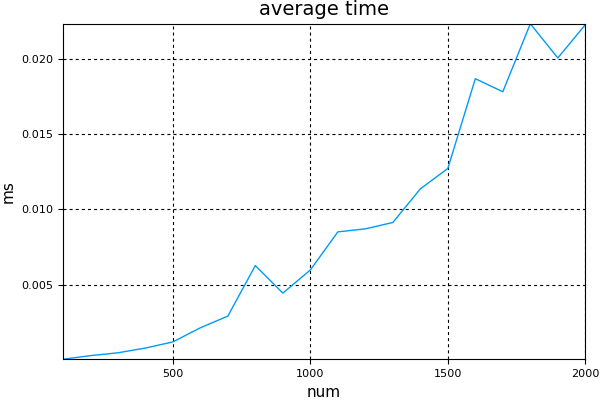

In [10]:
plot(range,
    vec(mean(sort(elapsed, 1)[1:loop-3, :], 1)),
    xlabel="num",
    ylabel="ms",
    legend=false,
    title="average time")

In [11]:
m, n = 10000, 10000
m_prefs, f_prefs = generate_random_prefs(m, n)
m_matched, f_matched = deferred_acceptance(m_prefs, f_prefs)
@time deferred_acceptance(m_prefs, f_prefs)

  0.951894 seconds (17 allocations: 763.322 MB, 8.75% gc time)


([3147,2750,3039,9061,8013,736,7687,4249,4305,9360  …  8869,5692,3237,3739,3321,9072,1604,9666,9435,9746],[619,9071,1552,7120,4956,6912,6869,8187,5037,158  …  9009,6990,1449,5738,5353,2228,1000,6658,8819,1260])

全体的に以前のコードより3~10倍早くなっています.